In [ ]:
# 4 agents: renewable, gas exit, gas entry, coal exit

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import linprog
import matplotlib
import matplotlib.pyplot as plt
import time
from cvxopt import solvers, matrix, sparse
from scipy.optimize import root_scalar
from scipy.sparse import bsr_matrix
from scipy.stats import gamma
from scipy.stats import beta
from scipy.linalg import block_diag
import random

In [2]:
# interval
Smin = 0.1
Smax = 0.7
Cmin = 0
Cmax = 120
tmin = 0
tmax = 30

# number for points
NS = 41
NC = 41
Nt = 101

# discretization
dS = 1.*(Smax-Smin)/(NS-1)
dC = 1.*(Cmax-Cmin)/(NC-1)
dt = 1.*(tmax-tmin)/(Nt-1)

# define grid in space
S = np.linspace(Smin,Smax,NS)
C = np.linspace(Cmin,Cmax,NC)
T = np.linspace(tmin,tmax,Nt)

# long-term average cost
theta_G = 37.94
theta_C = 22.5
theta_R = 0.4

# standard deviation
std_G = 12.53
std_C = 10
std_R = 0.075

# rate of mean reversion
kG = 0.5
kC = 0.5
kR = 0.5

# variability of the cost process 
delta_G = std_G*np.sqrt(2.*kG/theta_G)
delta_C = std_C*np.sqrt(2.*kC/theta_C)
delta_R = std_R*np.sqrt(2.*kR/(theta_R*(1-theta_R)-std_R*std_R))

rho = 0.08

epsilon = 0.5

# depreciation rate
gamma_G = np.log(2.)/15.
gamma_C = np.log(2.)/20.
gamma_R = np.log(2.)/12.5

# conversion of hourly revenue per MW into annual revenue per kW
convcoef = 24.*365.25/1000. 

# maximal price 
P = 150.

K_R = 1750. # per kW of installed capacity (who enter - fixing cost of owning the plant)
K_G_enter = 1450 # per kW of installed capacity (who enter - fixing cost of owning the plant)
K_G = 0 # per kW of installed capacity (who exit - value recovered if the plant is sold)
K_C = 0 # per kW of installed capacity (who exit - value recovered if the plant is sold)

# fixed cost
k_G = 42. # per kW per year
k_C = 68. # per kW per year
k_R = 30. # per kW per year

# coef carbon emission (tCO2/kWh)
ctax_G = 0.429
ctax_C = 0.986

# initial condition gas producers who exit
alpha_G = (theta_G/std_G)*(theta_G/std_G)
beta_G = theta_G/std_G/std_G
InitialOmega = 32*beta_G*gamma.pdf(beta_G*C,alpha_G)
# initial condition gas producers who enter
InitialLambda = 36.*beta_G*gamma.pdf(beta_G*C,alpha_G)
BarLambda = 36.*beta_G*gamma.pdf(beta_G*C,alpha_G)

# initial condition coal producers who exit
alpha_C = (theta_C/std_C)*(theta_C/std_C)
beta_C = theta_C/std_C/std_C
InitialMu = 44.9*beta_C*gamma.pdf(beta_C*C,alpha_C)

# initial condition renewable producers
alpha_R = theta_R*(theta_R*(1.-theta_R)/std_R/std_R-1.)
beta_R = (1.-theta_R)*(theta_R*(1.-theta_R)/std_R/std_R-1.)
BarEta = 118.3*beta.pdf(S,alpha_R,beta_R)
InitialEta = 64.*beta.pdf(S,alpha_R,beta_R)

# demand
demand = np.array([58.17932923,58.17932923,58.17932923,58.17932923
                    ,58.00821355,58.00821355,58.00821355,58.00821355
                    ,57.3709788,57.3709788,57.3709788,57.3709788
                    ,57.6659822,57.6659822,57.6659822,57.6659822
                    ,57.49486653,57.49486653,57.49486653,57.49486653
                    ,57.32375086,57.32375086,57.32375086,57.32375086
                    ,57.15263518,57.15263518,57.15263518,57.15263518
                    ,56.98151951,56.98151951,56.98151951,56.98151951
                    ,56.81040383,56.81040383,56.81040383,56.81040383
                    ,56.63928816,56.63928816,56.63928816,56.63928816
                    ,56.46817248,56.46817248,56.46817248,56.46817248
                    ,56.39972621,56.39972621,56.39972621,56.39972621
                    ,56.33127995,56.33127995,56.33127995,56.33127995
                    ,56.26283368,56.26283368,56.26283368,56.26283368
                    ,56.19438741,56.19438741,56.19438741,56.19438741
                    ,56.12594114,56.12594114,56.12594114,56.12594114
                    ,56.05749487,56.05749487,56.05749487,56.05749487
                    ,55.9890486,55.9890486,55.9890486,55.9890486
                    ,55.92060233,55.92060233,55.92060233,55.92060233
                    ,55.85215606,55.85215606,55.85215606,55.85215606
                    ,55.78370979,55.78370979,55.78370979,55.78370979
                    ,55.86356377,55.86356377,55.86356377,55.86356377
                    ,55.94341775,55.94341775,55.94341775,55.94341775
                    ,56.02327173,56.02327173,56.02327173,56.02327173
                    ,56.10312571,56.10312571,56.10312571,56.10312571
                    ,56.18297969,56.18297969,56.18297969,56.18297969
                    ,56.26283368,56.26283368,56.26283368,56.26283368
                    ,56.34268766,56.34268766,56.34268766,56.34268766
                    ,56.42254164,56.42254164,56.42254164,56.42254164
                    ,56.50239562,56.50239562,56.50239562,56.50239562
                    ,56.5822496,56.5822496,56.5822496,56.5822496])

# Adjusting for seasonal cycle
sc = np.array([[1.052491152, 0.962461095, 0.953705412, 1.037144059]])

sc = np.repeat(sc,len(demand)/4,axis=0)
sc = np.reshape(sc,1*len(demand))
demand[:101] = demand[:101]*sc[:101]
demand[100] = demand[100]*sc[0]

# peak / offpeak demand ratio
Dc = 1.257580634655325

# peak hours
pcoef = 65./168
# off-peak hours
opcoef = 1.-pcoef

# peak demand
pdemand = demand*Dc/(pcoef*Dc+opcoef)
# off-peak demand
opdemand = demand/(pcoef*Dc+opcoef)

# fonction G in the definition of the reward function for exit
def G(x):
    return (epsilon/2+(x-epsilon))*(x>epsilon)+x*x/2/epsilon*(x>0)*(x<=epsilon)

def F(x):
    return (x-epsilon>0)+x/epsilon*(x>0)*(x<=epsilon)

# baseline supply
def F0(X):
    return 17.5*X/150.

# fonction ptax - price carbon tax
def ptax(t):
    return 5.*t-10050 

# fonction g - payoff exit gas player
def g(x,p,t):
    return convcoef*G(p-x) - ctax_G*ptax(2020+t)*F(p-x) - k_G - (rho+gamma_G)*K_G*np.exp(-gamma_G*t)

# function h - payoff entry gas player
def h(x,p,t):
    return -convcoef*G(p-x) + ctax_G*ptax(2020+t)*F(p-x) + k_G + rho*K_G_enter + gamma_G*K_G_enter*np.exp(-(rho+gamma_G)*(tmax-t))

# fonction f - payoff entry renewable player
def f(x,p,t):
    return -convcoef*p*x + k_R + rho*K_R + gamma_R*K_R*np.exp(-(rho+gamma_R)*(tmax-t))

# fonction l - payoff exit coal player
def l(x,p,t):
    return convcoef*G(p-x) - ctax_C*ptax(2020+t)*F(p-x) - k_C - (rho+gamma_C)*K_C*np.exp(-gamma_C*t)

# residual demand
def computeR(eta,dem):
    maxdem = sum(S[:-1]*BarEta[0:NS-1])*dS
    Eta = np.reshape(eta,(Nt,NS))
    R = dem[:Nt]+np.matmul(Eta,S)*dS-maxdem
    return (R[:Nt]*(R[:Nt]>0))

# total supply by the conventional gas producers at prive level p
def computeM(l, p):
    maxdem = sum(F(p-C[:-1])*BarLambda[0:NC-1])*dC
    Lamb = np.reshape(l,(Nt,NS))
    M = maxdem - np.matmul(Lamb,F(p-C))*dC    
    return M 

# function which computes the price for given densities at a given time t
def price(t,R,O,L,M):
    if R[t]==0: return 0
    def func(x):
        return sum(F(x-C)*(O[t*NC:(t+1)*NC]+M[t*NC:(t+1)*NC]))*dC-R[t]+F0(x)+computeM(L,x)[t]
    if func(P)<=0: return P
    return root_scalar(func,bracket=(0.,P),x0 = P/2).root 

################################################################################################################
# find the maximum on omega at a given iteration
################################################################################################################
def OptExit_G(Omega,Eta,Lambda,Mu,Prp,Prop):
    # constraints    
    H=np.zeros(Nt*NC)
    for i in range(Nt):
        H[i*NC:(i+1)*NC]=dC*dt*np.exp(-rho*(T[i]))*(pcoef*g(C,Prp[i],T[i])+opcoef*g(C,Prop[i],T[i]))
    
    # neumann conditions
    A=np.zeros((NC,NC))
    V=1.+delta_G*delta_G*C*dt/(dC*dC)
    V1 =-delta_G*delta_G*C[1:]*dt/(2*dC*dC)+kG*(theta_G-C[1:])*dt/(2*dC)
    V2=-delta_G*delta_G*C[:-1]*dt/(2*dC*dC)-kG*(theta_G-C[:-1])*dt/(2*dC)
    A.flat[::NC+1] = V
    A.flat[1::NC+1] = V1
    A.flat[NC::NC+1] = V2

    A_ub = np.zeros(((Nt-1)*NC,(Nt-1)*NC))
    for i in range(Nt-1):
        A_ub[((i)*NC):((i+1)*NC), ((i)*NC):((i+1)*NC)] = A
    for i in range(Nt-2):
        A_ub[((i+1)*NC):((i+2)*NC), ((i)*NC):((i+1)*NC)] = -np.diag(np.ones(NC))
    b_ub=np.zeros((Nt-1)*NC)
    b_ub[:NC] = InitialOmega
    
    t0 = time.time()
    res = linprog(-H[NC:],A_ub,b_ub,method="highs-ipm")

    M1 = res.x
    val = np.dot(H[NC:],Omega[NC:])
    ob_func = np.dot(H[NC:],M1)- val
    t1 = time.time()

    return ob_func, val, M1

################################################################################################################
# find the maximum on lambda at a given iteration
################################################################################################################
def OptEntry_G(Omega,Eta,Lambda,Mu,Prp,Prop):
    # constraints    
    H=np.zeros(Nt*NC)
    for i in range(Nt):
        H[i*NC:(i+1)*NC]=dC*dt*np.exp(-rho*(T[i]))*(pcoef*h(C,Prp[i],T[i])+opcoef*h(C,Prop[i],T[i]))
    
    # neumann conditions
    A=np.zeros((NC,NC))
    V=1.+delta_G*delta_G*C*dt/(dC*dC)
    V1 =-delta_G*delta_G*C[1:]*dt/(2*dC*dC)+kG*(theta_G-C[1:])*dt/(2*dC)
    V2=-delta_G*delta_G*C[:-1]*dt/(2*dC*dC)-kG*(theta_G-C[:-1])*dt/(2*dC)
    A.flat[::NC+1] = V
    A.flat[1::NC+1] = V1
    A.flat[NC::NC+1] = V2

    
    A_ub = np.zeros(((Nt-1)*NC,(Nt-1)*NC))
    for i in range(Nt-1):
        A_ub[((i)*NC):((i+1)*NC), ((i)*NC):((i+1)*NC)] = A
    for i in range(Nt-2):
        A_ub[((i+1)*NC):((i+2)*NC), ((i)*NC):((i+1)*NC)] = -np.diag(np.ones(NC))
    b_ub=np.zeros((Nt-1)*NC)
    b_ub[:NC] = InitialLambda

    t0 = time.time()
    res = linprog(-H[NC:],A_ub,b_ub,method="highs-ipm")
    if(res.status): print('OpExit: '+res.message)

    M1 = res.x
    val = np.dot(H[NC:],Lambda[NC:])
    ob_func = np.dot(H[NC:],M1)- val
    t1 = time.time()

    return ob_func, val, M1

################################################################################################################
# find the maximum on eta at a given iteration
################################################################################################################
def OptEntry_R(Omega,Eta,Lambda,Mu,Prp,Prop):
    # constraints
    barH=np.zeros(Nt*NS)
    for i in range(Nt):
        barH[i*NS:(i+1)*NS]=dS*dt*np.exp(-rho*T[i])*(pcoef*f(S,Prp[i],T[i])+opcoef*f(S,Prop[i],T[i]))        
    
    # neumann conditions
    barA=np.zeros((NS,NS))
    barV=1.+delta_R*delta_R*S*(1-S)*dt/(dS*dS)
    barV1 = -delta_R*delta_R*S[1:]*(1.-S[1:])*dt/(2*dS*dS)+kR*(theta_R-S[1:])*dt/(2*dS)
    barV2 = -delta_R*delta_R*S[:-1]*(1.-S[:-1])*dt/(2*dS*dS)-kR*(theta_R-S[:-1])*dt/(2*dS)
    barA.flat[::NS+1] = barV
    barA.flat[1::NS+1] = barV1
    barA.flat[NS::NS+1] = barV2

    A_ub = np.zeros(((Nt-1)*NS,(Nt-1)*NS))
    for i in range(Nt-1):
        A_ub[((i)*NS):((i+1)*NS), ((i)*NS):((i+1)*NS)] = barA
    for i in range(Nt-2):
        A_ub[((i+1)*NS):((i+2)*NS), ((i)*NS):((i+1)*NS)] = -np.diag(np.ones(NS))
    b_ub=np.zeros((Nt-1)*NS)
    b_ub[:NS] = InitialEta

    t0 = time.time()
    res = linprog(-barH[NS:],bsr_matrix(A_ub),b_ub,method="interior-point",options={"sparse":True,"rr":False})
    if(res.status): print('OpEntry: '+res.message)

    M1 = res.x
    val = np.dot(barH[NS:],Eta[NS:])
    ob_func = np.dot(barH[NS:],M1)- val
    t1 = time.time()

    return ob_func, val, M1

################################################################################################################
# find the maximum on mu at a given iteration
################################################################################################################
def OptExit_C(Omega,Eta,Lambda,Mu,Prp,Prop):
    # constraints    
    H=np.zeros(Nt*NC)
    for i in range(Nt):
        H[i*NC:(i+1)*NC]=dC*dt*np.exp(-rho*(T[i]))*(pcoef*l(C,Prp[i],T[i])+opcoef*l(C,Prop[i],T[i]))
    
    # neumann conditions
    A=np.zeros((NC,NC))
    V=1.+delta_C*delta_C*C*dt/(dC*dC)
    V1 =-delta_C*delta_C*C[1:]*dt/(2*dC*dC)+kC*(theta_C-C[1:])*dt/(2*dC)
    V2=-delta_C*delta_C*C[:-1]*dt/(2*dC*dC)-kC*(theta_C-C[:-1])*dt/(2*dC)
    A.flat[::NC+1] = V
    A.flat[1::NC+1] = V1
    A.flat[NC::NC+1] = V2

    A_ub = np.zeros(((Nt-1)*NC,(Nt-1)*NC))
    for i in range(Nt-1):
        A_ub[((i)*NC):((i+1)*NC), ((i)*NC):((i+1)*NC)] = A
    for i in range(Nt-2):
        A_ub[((i+1)*NC):((i+2)*NC), ((i)*NC):((i+1)*NC)] = -np.diag(np.ones(NC))
    b_ub=np.zeros((Nt-1)*NC)
    b_ub[:NC] = InitialMu

    t0 = time.time()
    res = linprog(-H[NC:],A_ub,b_ub,method="highs-ipm")
    if(res.status): print('OpExit: '+res.message)

    M1 = res.x
    val = np.dot(H[NC:],Mu[NC:])
    ob_func = np.dot(H[NC:],M1)- val
    t1 = time.time()

    return ob_func, val, M1

In [3]:
start = time.time()

Niter=200 # total number of iterations
tol = 1. # convergence achieved if objective function less than tol

# initialisation of omega (exit for gas)
Omega=np.zeros(Nt*NC)
Omega[:NC]=InitialOmega

# initialisation of mu (exit for gas)
Mu=np.zeros(Nt*NC)
Mu[:NC]=InitialMu

# initialisation of lambda (entry for gas)
Lambda=np.zeros(Nt*NC)
Lambda[:NC]=InitialLambda

# initialisation of eta
Eta=np.zeros(Nt*NS)
Eta[:NS] = InitialEta

# peak and peak-off price value (historical)
prphist = np.zeros((Nt,Niter))
prophist = np.zeros((Nt,Niter))

# renewable produice energy
renpen = np.zeros((Nt,Niter))

# conventional gas exit capacity
g_exit_hist = np.zeros((Nt,Niter))
# conventional gas entry capacity
g_enter_hist = np.zeros((Nt,Niter))
# conventional coal capacity
c_hist = np.zeros((Nt,Niter))

# electricity produice
penhist = np.zeros((Nt,Niter))

# stock residual peak and off-peak demand value (historical)
RRp = np.zeros((Nt,Niter))
RRop = np.zeros((Nt,Niter))
Pr = np.zeros(Nt)

out1 = "Initial Objectives: Renewable: {:.2f}; Conventional gas exit:  {:.2f}; Conventional gas enter:  {:.2f}; Conventional coal exit:  {:.2f}; Total: {:.2f}"
out2 = "Weight: {:.4f}; Renewable: {:.2f}; Conventional gas exit:  {:.2f}; Conventional gas enter:  {:.2f}; Conventional coal exit:  {:.2f}; Total: {:.2f}"

# save objectives
save_ob_G = np.zeros(Niter)
save_ob_G_enter = np.zeros(Niter)
save_ob_C = np.zeros(Niter)
save_ob_R = np.zeros(Niter)

# residual peak and off-peak demand
Rp = computeR(Eta,pdemand)
Rop = computeR(Eta,opdemand)

# stock residual peak and off-peak demand value (historical)
RRp[:,0] = Rp
RRop[:,0] = Rop

Prp = np.zeros(Nt)
Prop = np.zeros(Nt)
for j in range(Nt):
    Prp[j] = price(j,Rp,Omega,Lambda,Mu)
    Prop[j] = price(j,Rop,Omega,Lambda,Mu)
    prphist[j,0] = Prp[j]
    prophist[j,0] = Prop[j]

# initialize
ob_G, val_G, Omega1=OptExit_G(Omega,Eta,Lambda,Mu,Prp,Prop)
ob_G_enter, val_G_enter, Lambda1=OptEntry_G(Omega,Eta,Lambda,Mu,Prp,Prop)
ob_C, val_C, Mu1=OptExit_C(Omega,Eta,Lambda,Mu,Prp,Prop)
ob_R, val_R, Eta1=OptEntry_R(Omega,Eta,Lambda,Mu,Prp,Prop)
print(out1.format(ob_R,ob_G,ob_G_enter,ob_C,ob_C+ob_G_enter+ob_G+ob_R))

for i in range(Niter):  

    save_ob_G[i] = ob_G
    save_ob_G_enter[i] = ob_G_enter
    save_ob_C[i] = ob_C
    save_ob_R[i] = ob_R

    if ob_R+ob_G < tol:
        print('Convergence achieved')
        Niter = i
        break

    print('Iteration ',i)   

    # reshape distribution 
    newEta = np.reshape(Eta,(Nt,NS))
    newOm = np.reshape(Omega,(Nt,NC))
    newLamb = np.reshape(Lambda,(Nt,NC))
    newMu = np.reshape(Mu,(Nt,NC))

    g_exit_hist[:,i] = np.sum(newOm,axis=1)*dC
    g_enter_hist[:,i] = np.sum(newLamb,axis=1)*dC
    c_hist[:,i] = np.sum(newMu,axis=1)*dC
    penhist[:,i] = np.sum(newEta,axis=1)*dS
    renpen[:,i] = np.sum(newEta*S,axis=1)*dS

    # step size
    weight = 1./(i+1)

    # upgrade the mesures
    Omega[NC:] = (1.-weight)*Omega[NC:]+weight*Omega1
    Lambda[NC:] = (1.-weight)*Lambda[NC:]+weight*Lambda1
    Mu[NC:] = (1.-weight)*Mu[NC:]+weight*Mu1
    Eta[NS:] = (1.-weight)*Eta[NS:]+weight*Eta1

    # residual peak and off-peak demand
    Rp = computeR(Eta,pdemand)
    Rop = computeR(Eta,opdemand)
    
    # stock residual peak and off-peak demand value (historical)
    if (i!=Niter-1):
        RRp[:,i+1] = Rp
        RRop[:,i+1] = Rop

    Prp = np.zeros(Nt)
    Prop = np.zeros(Nt)
    for j in range(Nt):
        Prp[j] = price(j,Rp,Omega,Lambda,Mu)
        Prop[j] = price(j,Rop,Omega,Lambda,Mu)
        if (i!=Niter-1):
            prphist[j,i+1] = Prp[j]
            prophist[j,i+1] = Prop[j]

    # search the solution
    ob_G, val_G, Omega1=OptExit_G(Omega,Eta,Lambda,Mu,Prp,Prop)
    ob_G_enter, val_G_enter, Lambda1=OptEntry_G(Omega,Eta,Lambda,Mu,Prp,Prop)
    ob_C, val_C, Mu1=OptExit_C(Omega,Eta,Lambda,Mu,Prp,Prop)
    ob_R, val_R, Eta1=OptEntry_R(Omega,Eta,Lambda,Mu,Prp,Prop)

    # advancement
    print(out2.format(weight,ob_R,ob_G,ob_G_enter,ob_C,ob_C+ob_G_enter+ob_G+ob_R))

end = time.time()
elapsed = end - start

print(elapsed)

Initial Objectives: Renewable: 67359.28; Conventional gas exit:  10.87; Conventional gas enter:  64890.31; Conventional coal exit:  94.94; Total: 132355.40
Iteration  0
Weight: 1.0000; Renewable: 247259.02; Conventional gas exit:  314191.70; Conventional gas enter:  305586.85; Conventional coal exit:  461058.03; Total: 1328095.60
Iteration  1
Weight: 0.5000; Renewable: 33045.05; Conventional gas exit:  7279.34; Conventional gas enter:  32901.65; Conventional coal exit:  19068.28; Total: 92294.32
Iteration  2
Weight: 0.3333; Renewable: 14017.86; Conventional gas exit:  3128.63; Conventional gas enter:  19593.03; Conventional coal exit:  7913.66; Total: 44653.19
Iteration  3
Weight: 0.2500; Renewable: 3666.14; Conventional gas exit:  11686.00; Conventional gas enter:  7938.02; Conventional coal exit:  19178.93; Total: 42469.09
Iteration  4
Weight: 0.2000; Renewable: 9347.68; Conventional gas exit:  3321.02; Conventional gas enter:  11724.64; Conventional coal exit:  6800.51; Total: 31193

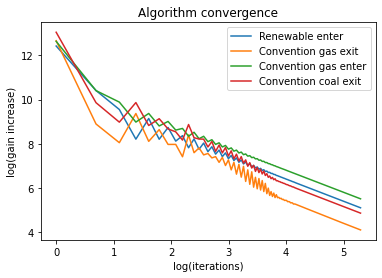

In [21]:
# Algorithm convergence illustration
logIter = np.log(range(1,Niter,1))

plt.figure()
plt.plot(logIter, np.log(save_ob_R[1:]), label = "Renewable enter")
plt.plot(logIter, np.log(save_ob_G[1:]), label = "Convention gas exit")
plt.plot(logIter, np.log(save_ob_G_enter[1:]), label = "Convention gas enter")
plt.plot(logIter, np.log(save_ob_C[1:]), label = "Convention coal exit")
plt.title("Algorithm convergence")
plt.xlabel('log(iterations)')
plt.ylabel('log(gain increase)')
plt.legend()
plt.show()

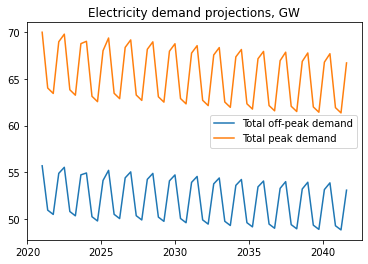

In [ ]:
# Electricity demand projections, GW
plt.figure()
plt.plot(2021+T[:56],opdemand[:56],label='Total off-peak demand')
plt.plot(2021+T[:56],pdemand[:56],label='Total peak demand')
plt.title('Electricity demand projections, GW')
plt.legend()
plt.show()

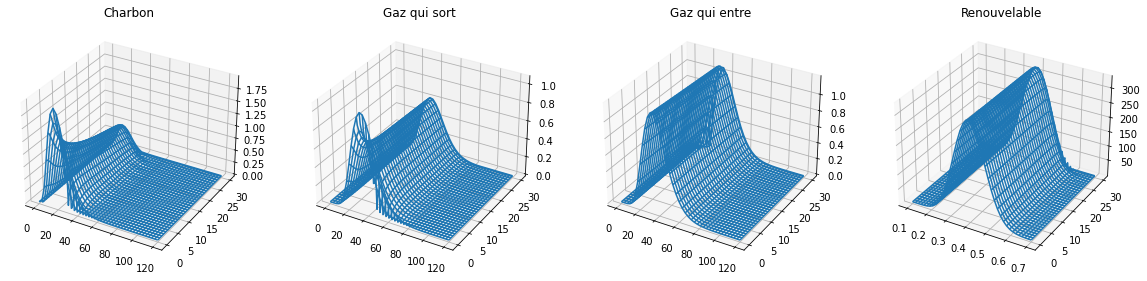

In [18]:
from mpl_toolkits.mplot3d import Axes3D # This import has side effects required for the kwarg projection='3d' in the call to fig.add_subplot

fig = plt.figure(figsize=(20,10))


newOm = np.reshape(Omega,(Nt,NC))
ax = fig.add_subplot(142, projection='3d')
XX, YY = np.meshgrid(C, T)
ax.plot_wireframe(XX, YY, newOm)
plt.title('Gaz qui sort')

newLamb = np.reshape(Lambda,(Nt,NC))
ax = fig.add_subplot(143, projection='3d')
XX, YY = np.meshgrid(C, T)
ax.plot_wireframe(XX, YY, newLamb)
plt.title('Gaz qui entre')

newMu = np.reshape(Mu,(Nt,NC))
ax = fig.add_subplot(141, projection='3d')
XX, YY = np.meshgrid(C, T)
ax.plot_wireframe(XX, YY, newMu)
plt.title('Charbon')

newEta = np.reshape(Eta,(Nt,NS))
XX, YY = np.meshgrid(S, T)
ax2 = fig.add_subplot(144, projection='3d')
ax2.plot_wireframe(XX, YY, newEta)
plt.title('Renouvelable')

plt.savefig("distri_S0")

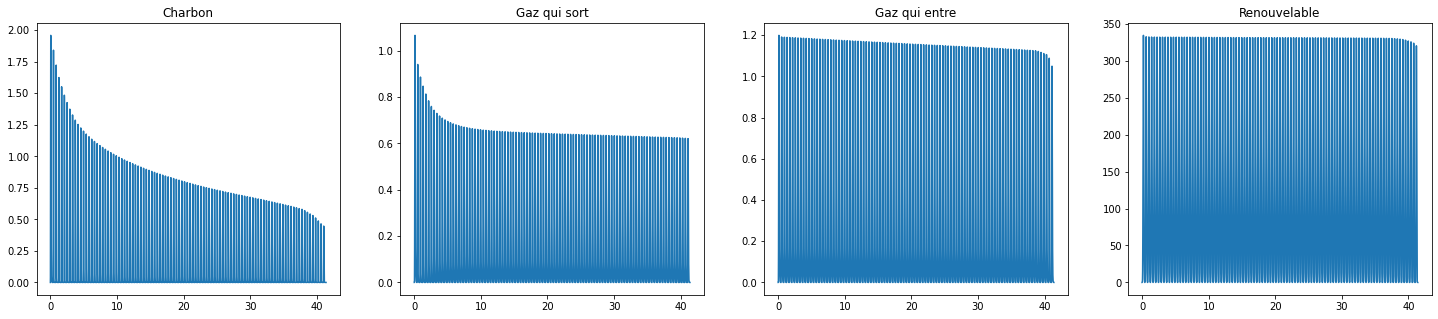

In [20]:
fig = plt.figure(figsize=(25,5))

plt.subplot(1,4,2)
plt.plot(Omega)
plt.title('Gaz qui sort')
plt.xticks([0,1000,2000,3000,4000],[0,10,20,30,40])

plt.subplot(1,4,3)
plt.plot(Lambda)
plt.title('Gaz qui entre')
plt.xticks([0,1000,2000,3000,4000],[0,10,20,30,40])

plt.subplot(1,4,1)
plt.plot(Mu)
plt.title('Charbon')
plt.xticks([0,1000,2000,3000,4000],[0,10,20,30,40])

plt.subplot(1,4,4)
plt.plot(Eta)
plt.title('Renouvelable')
plt.xticks([0,1000,2000,3000,4000],[0,10,20,30,40])

plt.savefig("distri_lateral")

Text(0.5, 1.0, 'Renouvelable')

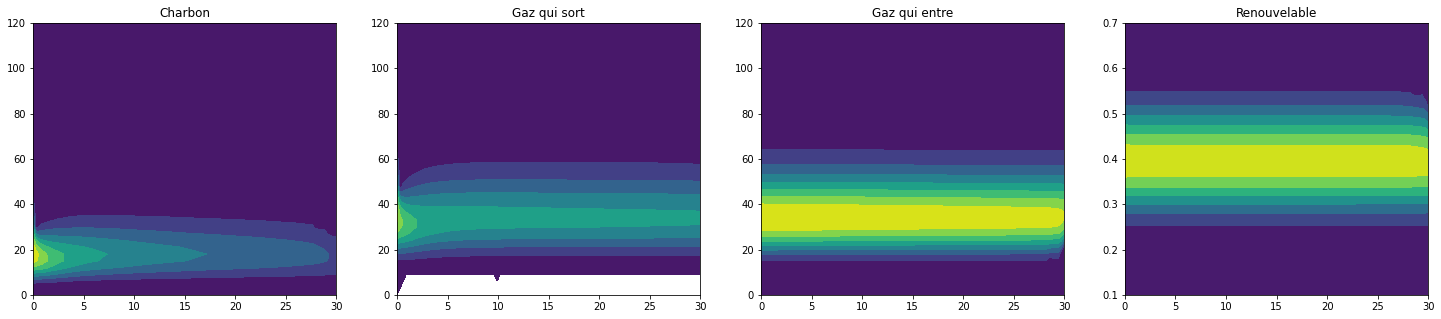

In [21]:
plt.figure(figsize=(25,5))

plt.subplot(1,4,2)
XX, YY = np.meshgrid(C, T)
plt.contourf(YY, XX, newOm)
plt.title('Gaz qui sort')

plt.subplot(1,4,3)
XX, YY = np.meshgrid(C, T)
plt.contourf(YY, XX, newLamb)
plt.title('Gaz qui entre')

plt.subplot(1,4,1)
XX, YY = np.meshgrid(C, T)
plt.contourf(YY, XX, newMu)
plt.title('Charbon')

plt.subplot(1,4,4)
XX, YY = np.meshgrid(S, T)
plt.contourf(YY, XX, newEta)
plt.title('Renouvelable')

<ipython-input-28-25eb58102382>:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('231')
<ipython-input-28-25eb58102382>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('232')
<ipython-input-28-25eb58102382>:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('233')
<ipython-input-28-25eb58102382>:27: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('234')
<ipython-input-28-25eb58102382>:33: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is

Text(0.5, 1.0, 'Conventional installed capacity')

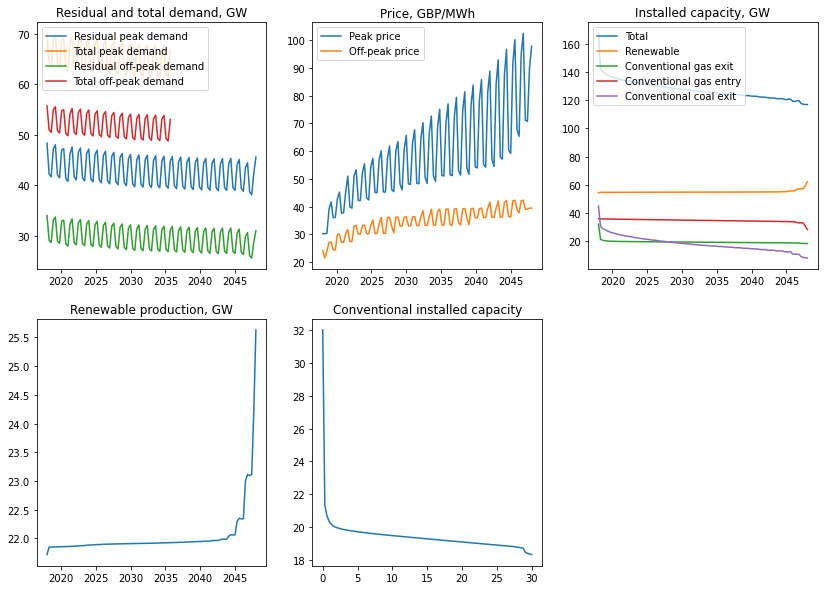

In [28]:
plt.figure(figsize=(14,10))

plt.subplot('231')
plt.plot(2018+T,RRp[:,Niter-1],label='Residual peak demand')
plt.plot(2018+T[:60],pdemand[:60],label='Total peak demand')
plt.plot(2018+T,RRop[:,Niter-1],label='Residual off-peak demand')
plt.plot(2018+T[:60],opdemand[:60],label='Total off-peak demand')
plt.title('Residual and total demand, GW')
plt.legend(loc=2)

plt.subplot('232')
plt.plot(2018+T,prphist[:,Niter-1],label='Peak price')
plt.plot(2018+T,prophist[:,Niter-1],label='Off-peak price')
plt.legend(loc=2)
plt.title('Price, GBP/MWh')

plt.subplot('233')
renhist = np.ones(penhist.shape)*np.sum(BarEta)*dS-penhist
plt.plot(2018+T,renhist[:,Niter-1]+g_exit_hist[:,Niter-1]+g_enter_hist[:,Niter-1]+c_hist[:,Niter-1],label='Total')
plt.plot(2018+T,renhist[:,Niter-1],label='Renewable')
plt.plot(2018+T,g_exit_hist[:,Niter-1],label='Conventional gas exit')
plt.plot(2018+T,g_enter_hist[:,Niter-1],label='Conventional gas entry')
plt.plot(2018+T,c_hist[:,Niter-1],label='Conventional coal exit')
plt.legend(loc=2)
plt.title('Installed capacity, GW')

plt.subplot('234')
plt.plot(2018+T,np.sum(BarEta*S)*dS-renpen[:,Niter-1])
plt.title('Renewable production, GW')

#plt.savefig('industry_dynamics_peak_offpeak_baseline.pdf',format='pdf')

plt.subplot('235')
plt.plot(T,g_exit_hist[:,-1])
plt.title('Conventional installed capacity')

In [30]:
print(prphist[:,Niter-1])

[ 30.25315744  30.25802709  30.44337154  39.01769247  41.71707568
  36.02953017  36.1098136   42.70951146  45.25493109  37.67158804
  37.86237355  45.47902482  51.02627901  39.93546938  39.4690123
  51.01757481  53.33131173  42.26661365  42.1942853   52.20260593
  55.46729745  43.16187681  42.43749894  54.34210958  57.38076318
  45.16589894  45.04450798  57.02426295  60.12040037  45.35478269
  45.22822434  57.46868015  61.8763652   46.18864554  45.39365841
  60.11509998  63.45513317  48.07810894  46.0539716   60.63184872
  65.71170065  48.21434328  48.04517991  63.05049593  67.64793159
  48.42213993  48.23407264  64.74725059  70.26787008  50.54989179
  48.40344779  66.49742401  72.63620237  51.12692063  49.09641785
  68.92887673  75.04003145  51.281678    51.04182973  70.23516985
  77.03540948  51.45539694  51.20906777  72.38888878  79.39447834
  53.09921063  51.34754445  74.48083078  81.40348308  54.11081706
  51.61860953  76.46628924  83.74886155  54.31352876  53.94643606
  78.395646

In [32]:
print(prophist[:,Niter-1])

[24.22552417 21.49995249 24.04538288 27.07736584 27.29408444 24.40394055
 24.4506355  30.00993558 30.14302428 27.16510205 27.1826552  30.29590191
 31.7762043  27.46434738 27.45963116 33.05732841 33.2166263  30.11079956
 30.09004949 33.24453236 33.39320025 30.25599597 30.22658696 33.39255227
 35.18169972 30.37149097 30.33476716 33.87828763 36.10475596 30.46374455
 30.42298459 36.0628705  36.20933232 33.00107798 30.57547662 36.15915062
 36.30247643 33.07749669 33.02641668 36.23868812 36.37770967 33.14162119
 33.08781324 36.30584675 36.46139894 33.21445909 33.16049403 36.3912295
 38.63438344 33.28619671 33.23092961 36.47185266 39.08118534 33.35238705
 33.29383382 38.24222204 39.15373004 33.40903134 33.34865213 39.04971087
 39.22196166 33.46162266 33.40134377 39.11943274 39.29179219 34.18716963
 33.45209781 39.18257997 39.35352337 36.01274703 33.51480673 39.24625665
 39.41709527 36.06691646 35.93849343 39.30884816 39.4786548  36.12438768
 36.05781587 39.38337886 41.66088307 36.18642229 36.

In [24]:
print(g_enter_hist[:,Niter-1])

[35.99985522 35.81153703 35.76664226 35.74409445 35.72206639 35.70031735
 35.67873264 35.65725344 35.63584746 35.61449582 35.5931868  35.57191276
 35.55066848 35.52945024 35.50825534 35.4870817  35.46592775 35.44479225
 35.42367419 35.40257278 35.38148736 35.36041737 35.33936239 35.31832202
 35.29729595 35.27628391 35.25528568 35.23430106 35.21332988 35.192372
 35.1714273  35.15049568 35.12957704 35.1086713  35.08777839 35.06689825
 35.04603083 35.02517608 35.00433395 34.98350442 34.96268744 34.94188299
 34.92109105 34.90031158 34.87954457 34.85879    34.83804784 34.81731809
 34.79660072 34.77589573 34.75520309 34.7345228  34.71385485 34.69319922
 34.6725559  34.65192488 34.63130616 34.61069972 34.59010555 34.56952365
 34.548954   34.5283966  34.50785144 34.48731852 34.46679781 34.44629425
 34.42579682 34.4053153  34.38484318 34.3643834  34.34393584 34.32350046
 34.30307725 34.28266619 34.26226728 34.24188051 34.22150588 34.20114337
 34.18079297 34.15919491 34.13824096 34.11797643 34.0

In [25]:
print(g_exit_hist[:,Niter-1])

[31.99987131 21.33520466 20.70183634 20.364052   20.18388233 20.06965908
 20.0005201  19.95690866 19.91898878 19.88162266 19.85354081 19.83096077
 19.80881757 19.78407864 19.76441543 19.74705057 19.72910907 19.70947618
 19.69319319 19.67807765 19.66284897 19.64631908 19.63188998 19.61837458
 19.60478208 19.58957674 19.57645621 19.56369386 19.55079153 19.53722206
 19.52457761 19.51225405 19.49991104 19.48713194 19.47494454 19.46286101
 19.45081925 19.43856916 19.42665731 19.41480263 19.40296603 19.39103366
 19.3792849  19.36757856 19.35588446 19.34415664 19.33252217 19.32090233
 19.3092973  19.29768847 19.28612637 19.27458889 19.2630606  19.25151975
 19.24001896 19.22853442 19.21705331 19.20557177 19.19411279 19.18266433
 19.17122345 19.15978792 19.14836685 19.13695207 19.12554487 19.11414237
 19.10275479 19.09137358 19.07999851 19.06863007 19.05727466 19.04592474
 19.0345811  19.02324143 19.01191332 19.00059113 18.98927497 18.97796515
 18.96666411 18.95536804 18.94407718 18.93278926 18

In [26]:
print(c_hist[:,Niter-1])

[44.90047032 30.44729702 29.05296667 28.28644218 27.39071607 26.80852185
 26.21642933 25.86536684 25.43772785 24.96356343 24.65811488 24.36520503
 24.05138848 23.707609   23.49474401 23.28780969 23.05286942 22.70691126
 22.48834143 22.27072966 22.03887431 21.76742303 21.54075892 21.40971628
 21.25052457 20.94503653 20.80531904 20.65928615 20.50328532 20.19703502
 20.06300552 19.92514785 19.77827519 19.47448129 19.35020712 19.26566958
 19.10379612 18.88858916 18.7508638  18.67030321 18.575104   18.33696394
 18.19981712 18.12201163 18.03022718 17.70262342 17.62862033 17.55118341
 17.46419896 17.16494229 17.09198913 17.02717778 16.96988479 16.75113566
 16.67102972 16.62159808 16.56144832 16.33166285 16.25529072 16.20736408
 16.14545151 15.87207537 15.80322678 15.75849756 15.70283289 15.48299028
 15.41083808 15.36965875 15.32013638 15.09081214 14.9749398  14.94931039
 14.91585986 14.66080656 14.58987512 14.56431908 14.53221199 14.17232117
 14.08556723 14.06456871 14.0370269  13.70593723 13

In [30]:
print(renhist[:,Niter-1])

[54.29895728 54.62287338 54.62487507 54.62677641 54.62863552 54.63047406
 54.63230168 54.63431039 54.6364361  54.63832747 54.64040409 54.64464107
 54.64935116 54.65130918 54.65447461 54.66498844 54.67118325 54.6738531
 54.67832514 54.68939955 54.69670801 54.69905071 54.7028043  54.71221576
 54.7163999  54.71881508 54.7215421  54.73154316 54.73443297 54.73654851
 54.73884903 54.74342335 54.74614303 54.74802877 54.75019764 54.75296846
 54.75514163 54.75700495 54.75892252 54.7615697  54.76355688 54.76537825
 54.76725119 54.76959231 54.77163217 54.77345768 54.7753721  54.7778636
 54.77983475 54.78165942 54.78356737 54.78665755 54.78876393 54.79061779
 54.79262768 54.79661115 54.79894001 54.80084112 54.80301911 54.80663546
 54.80961039 54.81149025 54.81361837 54.81868719 54.82132195 54.82319344
 54.82529211 54.832599   54.83570796 54.83763183 54.83993291 54.84634707
 54.85080596 54.85283129 54.85548742 54.86426026 54.8679272  54.86991934
 54.87249549 54.88904954 54.89335698 54.89537513 54.8